# Calculating Frequency

This notebook demonstrates how to calculate frequency from raw waveform data.

In [1]:
import btrdb
from btrdb.utils.timez import *

import pandas as pd
import numpy as np
import os

from matplotlib import pyplot as plt

import utils

%load_ext autoreload
%autoreload 2

In [2]:
db = btrdb.connect()
stream = db.stream_from_uuid('484eca4b-bd58-4bce-9031-26357e699adf')

utils.print_stream_summary(stream)


        Collection: POW/GridSweep
        Measurement: voltage
        Duration: 24.0 hours
        Size: 377.69 million points
        


Text(0, 0.5, 'voltage (volts)')

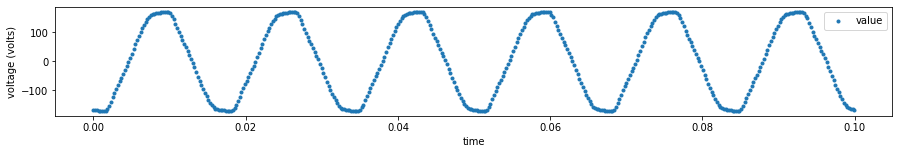

In [3]:
start, _ = stream.earliest()
end, _ = stream.latest()

dt = ns_delta(seconds=0.5)
raw_points = stream.values(start.time, start.time+dt)
df = utils.points_to_dataframe(raw_points, resolution='full', convert_time_to='relative')


fig, ax = plt.subplots(figsize=(15,2))
df.loc[:0.1].plot(y='value', ax=ax, ls=' ', marker='.')
ax.set_ylabel(f'{stream.name} ({stream.unit})')

In [4]:
def count_zero_crossings(statpoints, return_index=True):
    count = 0
    z_index = []
    previous = statpoints[0][0]
        
    for i, (point, _) in enumerate(statpoints):
        z_index.append(i)
        
        if (point.min <= 0) and (point.max >= 0):
            # count if zero crossing is within interval
            count += 1

        elif i == 0:
            pass
        
        else:
            # count if zero crossing occurs between current and preceeding interval
            if (point.min >= 0) and (statpoints[i-1][0].max <= 0):
                # covers ascending case
                count += 1
                
            # count if zero crossing occurs between current and preceeding interval
            elif (point.max <= 0) and (statpoints[i-1][0].min >= 0):
                # covers descending case
                count += 1
                
            else:
                z_index = z_index[:-1]
    
    if return_index == True:
        return count, z_index
    else:
        return count
        

In [5]:
attrs = ['time','mean','min','max','count']
pw = int(np.log2(ns_delta(seconds=1/60/4)))

statpoints = stream.aligned_windows(start.time, start.time+dt, pw)
count, z_index = count_zero_crossings(statpoints, return_index=True)
print(count, (count/2)/(dt/1e9))

60 60.0


In [6]:
zero_crossing_data = []

for z in z_index:
    t0 = statpoints[z][0].time
    tf = t0 + 2**pw
    
    points = stream.values(t0, tf)
    zero_crossing_data.append(utils.points_to_dataframe(points, 
                                                        resolution='full',
                                                        convert_time_to='relative',
                                                        t0=stream.earliest()[0].time))


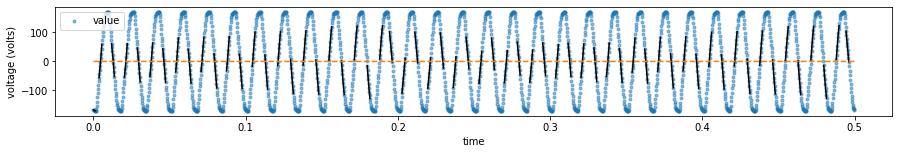

In [7]:
fig, ax = plt.subplots(figsize=(15,2))
df.plot(y='value', ax=ax, ls=' ', marker='.', alpha=0.5)
ax.set_ylabel(f'{stream.name} ({stream.unit})')

for z_series in zero_crossing_data:
    ax.plot(z_series.index, z_series['value'], color='k')
    
pd.Series(0, index=df.index).plot(ax=ax, ls='--')
plt.show()